In [6]:
import pmdarima as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [12]:
goog = df[df['Name']=='GOOG']['Close']
goog.head()

Date
2010-01-04    312.204773
2010-01-05    310.829926
2010-01-06    302.994293
2010-01-07    295.940735
2010-01-08    299.885956
Name: Close, dtype: float64

<Axes: xlabel='Date'>

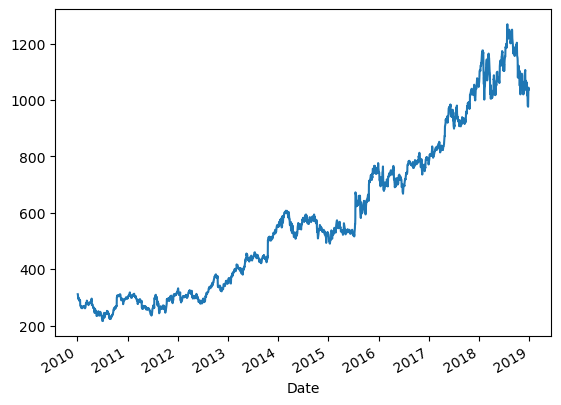

In [13]:
goog.plot()

In [14]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

In [15]:
model = pm.auto_arima(train,
                     error_action='ignore', trace=True,
                     supress_warnings=True, maxiter=10,
                     seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16270.771, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16270.383, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16269.726, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16269.492, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16271.123, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16268.077, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16267.935, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16268.277, Time=0.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16266.968, Time=1.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16264.983, Time=0.92 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16266.925, Time=1.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16268.907, Time=1.52 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16265.470, Time=0.39 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 10.261 seconds


In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8127.491
Date:                Sat, 13 Jan 2024   AIC                          16264.983
Time:                        20:00:48   BIC                          16293.536
Sample:                             0   HQIC                         16275.409
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3104      0.198      1.571      0.116      -0.077       0.698
ar.L1          0.0378      0.012      3.152      0.002       0.014       0.061
ar.L2         -0.0410      0.013     -3.241      0.001      -0.066      -0.016
ar.L3          0.0488      0.012      4.031      0.000       0.025       0.073
sigma2        85.1623      1.033     82.421      0.000      83.137      87.187
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11790.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Above we can see that auto regressive component has order three, that means the last three days of data might be useful in predicting the next return.

In [18]:
model.get_params()

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (3, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [21]:
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]
    
    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
    
    fig, ax = plt.subplots(figsize = (10,5))
    ax.plot(fulldata.index, fulldata, label = 'data')
    ax.plot(train.index[d:], train_pred, label = 'fitted')
    ax.plot(test.index, test_pred, label = 'forecast')
    ax.fill_between(test.index, \
                   confint[:,0], confint[:,1], \
                   color = 'red', alpha=0.3)
    ax.legend()
    

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


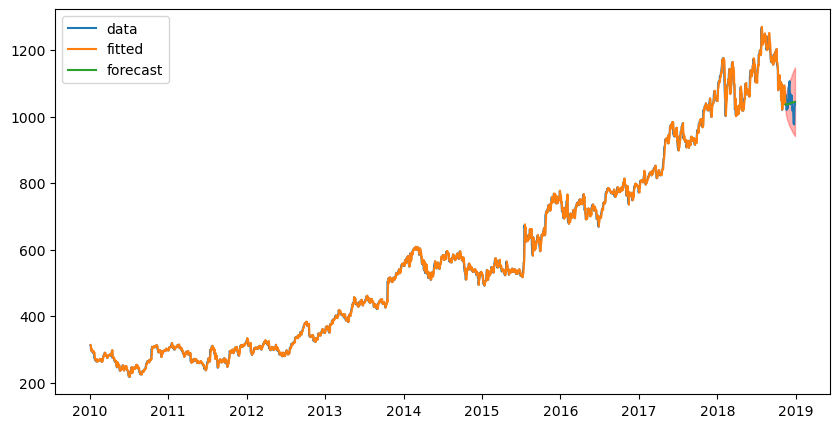

In [22]:
plot_result(model,goog,train,test)

In [28]:
def plot_test(model, test):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(test.index, test, label='true')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, \
                   confint[:,0], confint[:,1], \
                   color='red', alpha=0.3)
    ax.legend()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


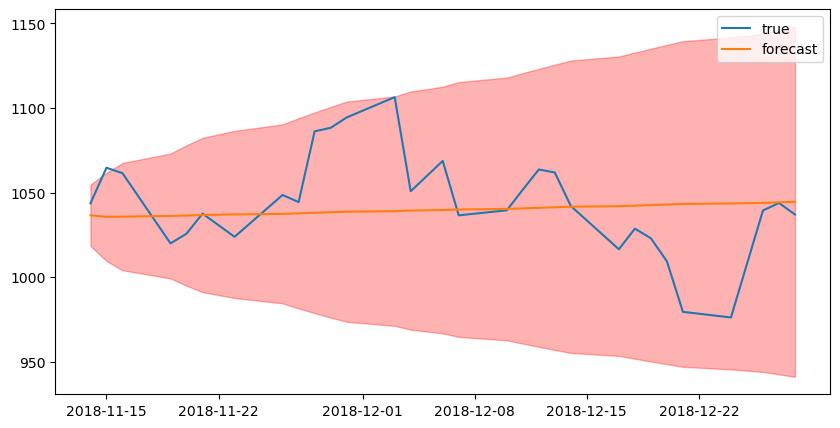

In [29]:
plot_test(model, test)